<a href="https://colab.research.google.com/github/fedefliguer/trading/blob/master/v1/v1_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/fedefliguer/trading/master/v1/v1.csv'

base = pd.read_csv(url, index_col=0)
base['fc'] = pd.to_datetime(base['fc'], errors='coerce')


### XGBoost

In [ ]:
month = base['fc'].dt.strftime('%Y%m')
month = pd.to_numeric(month)
if 'month' not in base:
  base.insert (1, "month", month)

base = base[(base.target) < 90] # Elimina indeterminados
base = base.sort_values(by=['fc'])
un_quintos = int(len(base)/5)
dos_quintos = int(len(base)/5)*2
cuatro_quintos = int(len(base)/5)*4
base_params = base.iloc[un_quintos:dos_quintos]
base_train = base.iloc[dos_quintos:cuatro_quintos]
base_test = base.iloc[cuatro_quintos:(len(base)-180)]

# Parametrizo

X=base_params.iloc[:, 7:].drop("target", 1)
targets=base_params.target

pred_train, pred_test, tar_train, tar_test = train_test_split(X, targets, test_size=.4)
eval_set = [(pred_train, tar_train),(pred_test, tar_test)]

bst=XGBClassifier(objective= 'binary:logistic',seed=5)
params = {  
    "n_estimators": st.randint(15, 100),
    "max_depth": st.randint(3, 4),
    "learning_rate": st.uniform(0.05, 0.3),
    "colsample_bytree": st.beta(10, 1) ,
    "subsample": st.beta(10, 1)  ,
    "gamma": st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50),
    "min_child_weight": st.expon(0, 50)
                         }
gs = RandomizedSearchCV(bst, params,  n_iter=30, n_jobs=1,cv=4 )  
bst=gs.fit(pred_train, tar_train,eval_set=eval_set, eval_metric=["auc"],early_stopping_rounds=10) 

# Entreno

X=base_train.iloc[:, 7:].drop("target", 1)
targets=base_train.target

pred_train, pred_test, tar_train, tar_test = train_test_split(X, targets, test_size=.4)
eval_set = [(pred_train, tar_train),(pred_test, tar_test)]

classif = XGBClassifier(**bst.best_params_)
model=classif.fit(pred_train,tar_train,eval_set=eval_set, eval_metric=["auc"],early_stopping_rounds=10)
results = model.evals_result()



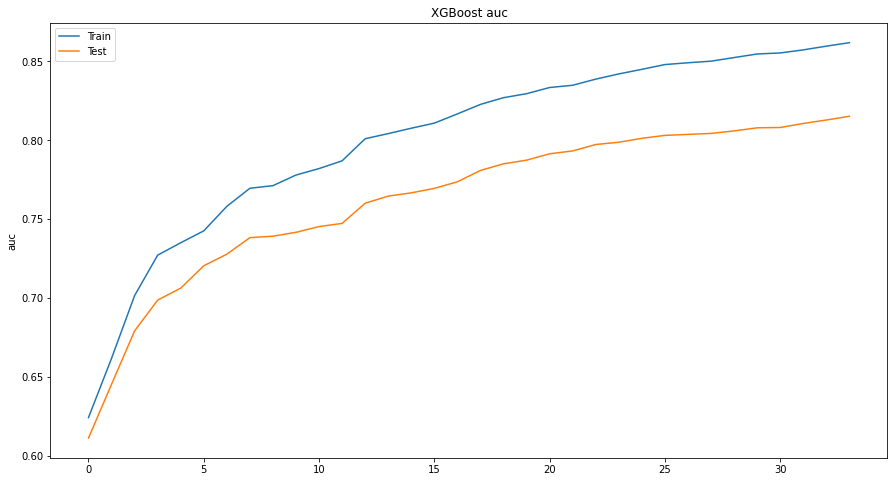

,0
precio_proyectado_techo_vivo_mas_cercano_4,0.066862
tendencia_piso_vivo_mas_probado_30,0.029928
tendencia_piso_vivo_mas_probado_60,0.024626
tendencia_techo_vivo_mas_probado_30,0.023999
exp2,0.023827
...,...
nu_dias_histog_mismo_signo_90,0.005495
precio_proyectado_techo_vivo_mas_cercano_360,0.005080
nu_dias_histog_negativo_90,0.004961
var_exp2_2,0.004331


In [ ]:
# Análisis

epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost auc')
plt.show()

importancia=model.feature_importances_ 
importancia=pd.DataFrame(importancia)
importancia=importancia.transpose()
importancia.columns=X.columns
b=importancia
c=b.transpose()
r=pd.DataFrame(c).loc[(c[0]>0),].sort_values([0],ascending=False)
r

In [ ]:
# Test

X=base_test.iloc[:, 7:].drop("target", 1)
targets=base_test.target

preds = model.predict_proba(X)
A = preds[:,1]
data_ks=pd.DataFrame(targets)
data_ks['prob_suba'] = A
data_ks['bucket'] = pd.qcut(data_ks.prob_suba, 50)
data_ks['no_target'] = 1 - data_ks['target']
grouped = data_ks.groupby('bucket', as_index = False)

agg1 = grouped.min().prob_suba
agg1 = pd.DataFrame({'min_prob_suba': grouped.min().prob_suba})
agg1['max_prob_suba'] = grouped.max().prob_suba
agg1['targets'] = grouped.sum().target
agg1['no_targets'] = grouped.sum().no_target
agg1['total'] = agg1.targets + agg1.no_targets
agg1['ganancia_esperada'] = (agg1.targets/agg1.total)*(0.14-0.015) - (agg1.no_targets/agg1.total)*(0.06-0.015)

agg1


,min_prob_suba,max_prob_suba,targets,no_targets,total,ganancia_esperada
0,0.048027,0.144513,44,131,175,-0.002257
1,0.144709,0.176358,40,134,174,-0.005920
2,0.176468,0.195940,48,126,174,0.001897
3,0.195988,0.213671,48,127,175,0.001629
4,0.213698,0.228802,50,126,176,0.003295
5,0.228893,0.240506,41,131,172,-0.004477
6,0.240550,0.252082,48,126,174,0.001897
7,0.252255,0.263301,46,128,174,-0.000057
8,0.263340,0.274029,47,127,174,0.000920
9,0.274123,0.283936,53,122,175,0.006486


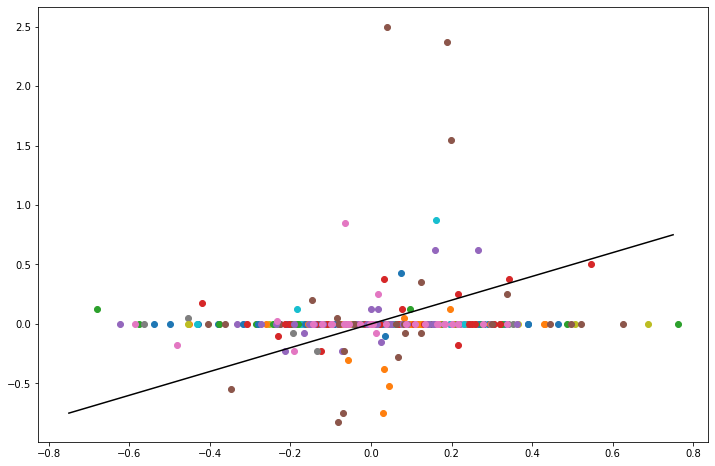

In [ ]:
import numpy as np

id_test = base_test.iloc[:, 0:4]
id_test
id_test['pred'] = preds[:,1]
id_test['efec'] = base_test.target
id_test['result'] = np.where(((id_test['pred'] > 0.75) & (id_test['efec'] == 1)), 0.14 - 0.015, 
                    np.where(((id_test['pred'] > 0.75) & (id_test['efec'] == 0)), -0.06 - 0.015, 
                   0))

resumen = []

for activo in id_test.ticker.unique():
  un_activo = id_test[(id_test.ticker == activo)]
  for mes in un_activo.month.unique():
    un_mes = un_activo[(un_activo.month == mes)]
    ganancia_mensual = (un_mes.y[un_mes.index[-1]]/un_mes.y[un_mes.index[0]])-1
    ganancia_modelo = un_mes.result.sum()
    resumen.append([activo, mes, ganancia_modelo, ganancia_mensual])

ganancias = pd.DataFrame(resumen, columns=['activo', 'mes', 'ganancia_modelo', 'ganancia_mensual'])
groups = ganancias.groupby("activo")


plt.figure(figsize=(12,8))
for name, group in groups:
    plt.plot(group["ganancia_mensual"], group["ganancia_modelo"], marker="o", linestyle="", label=name)
orig = np.linspace(-0.75,0.75,3)
plt.plot(orig,orig,'k-') # identity line

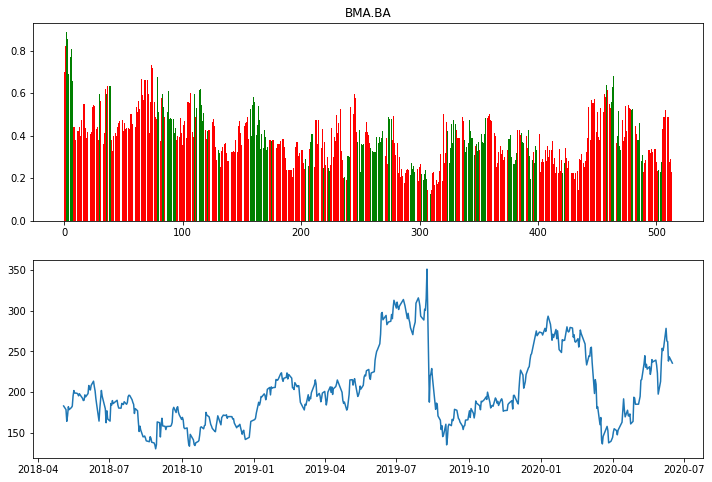

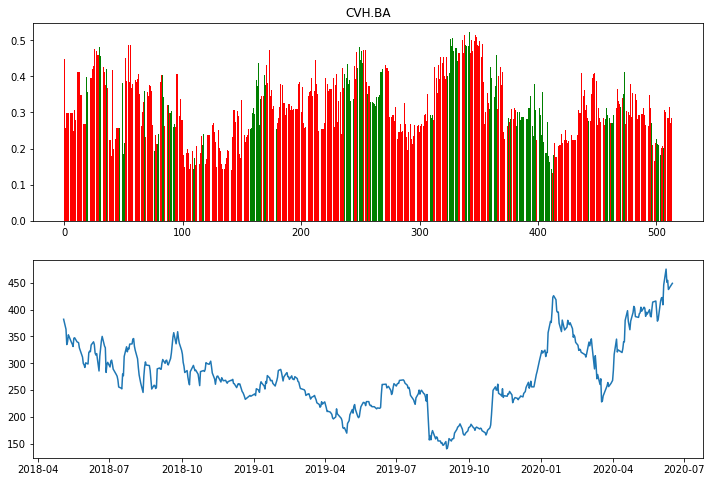

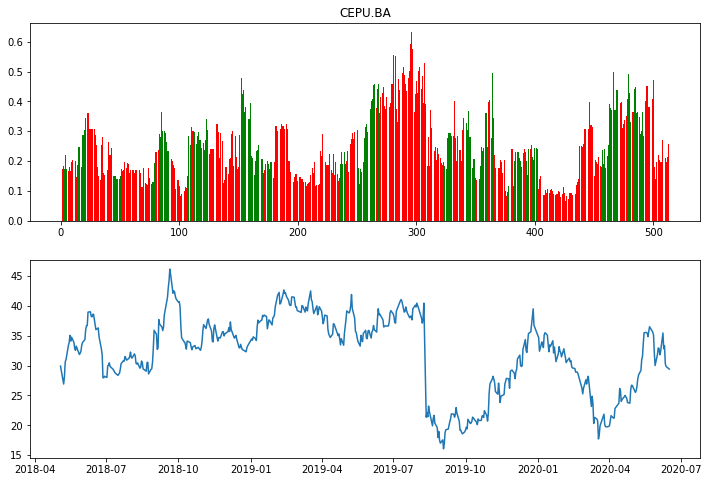

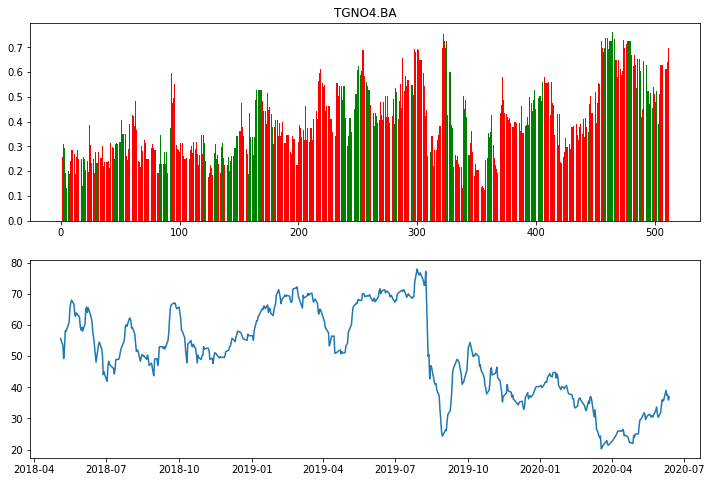

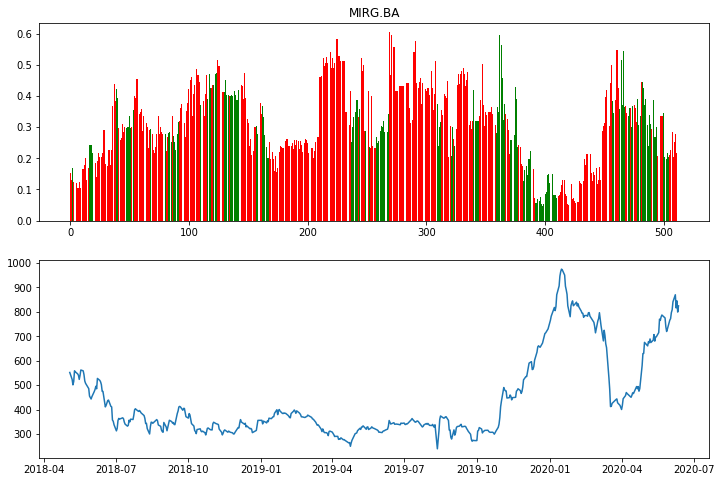

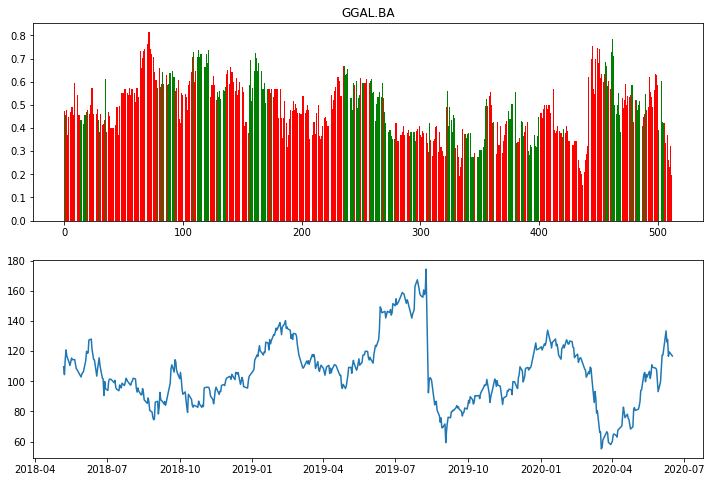

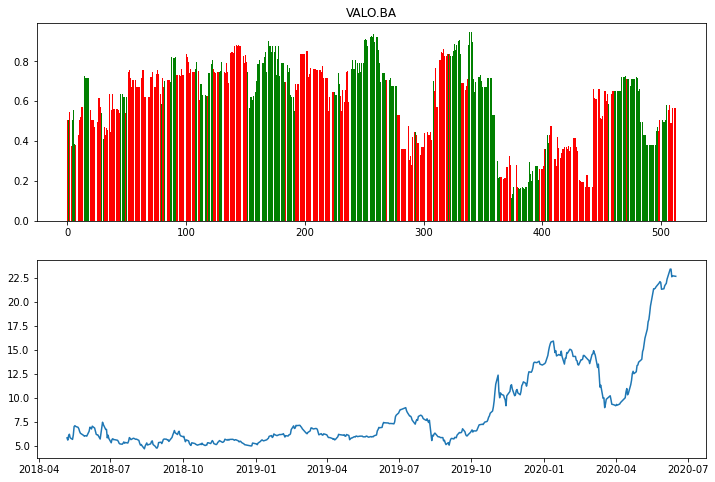

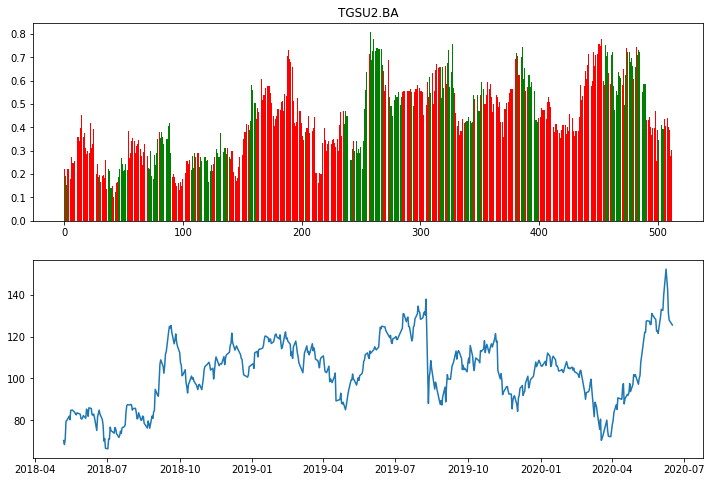

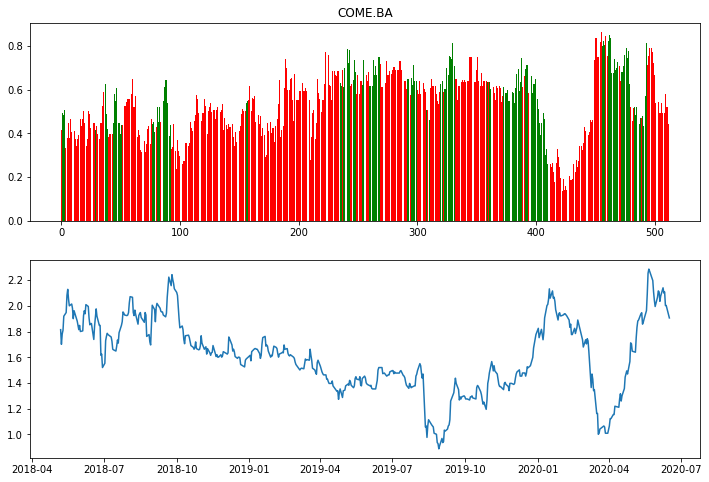

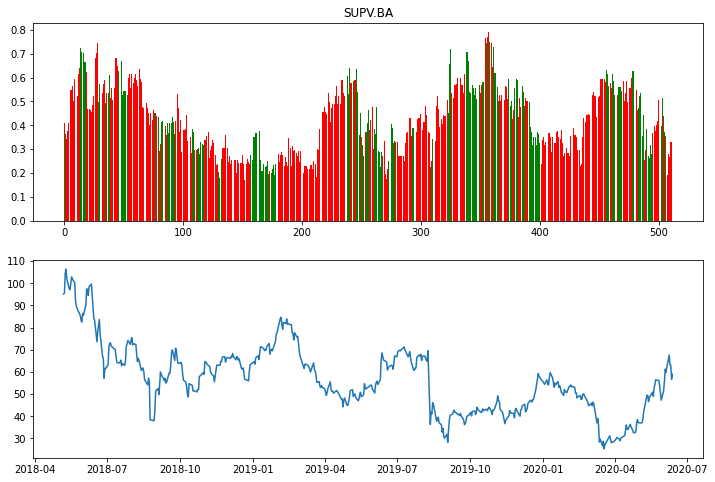

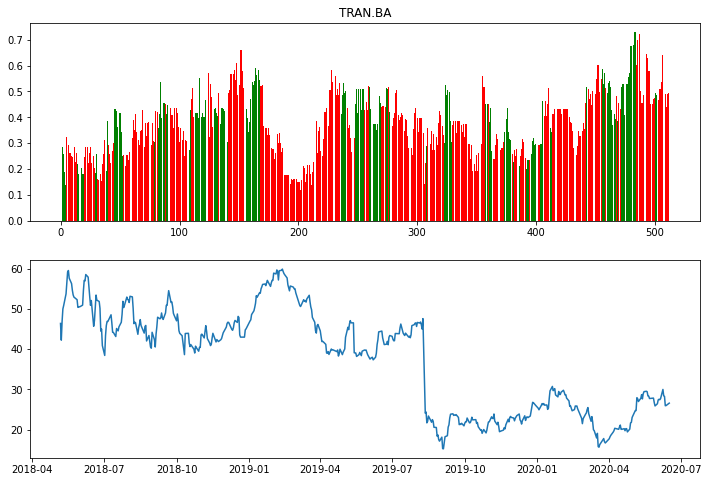

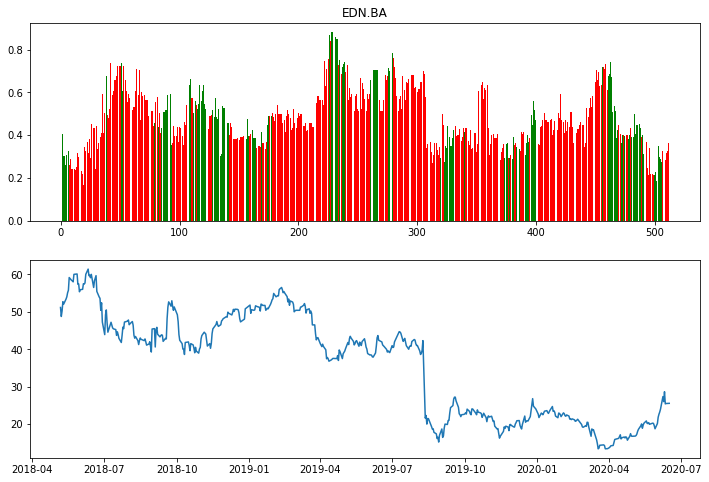

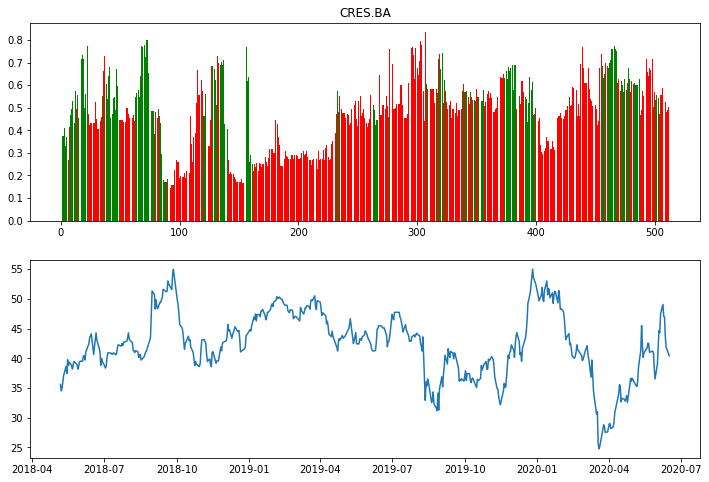

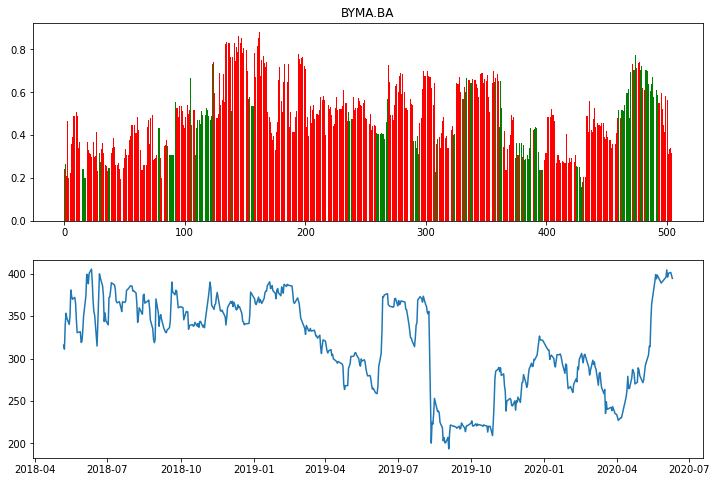

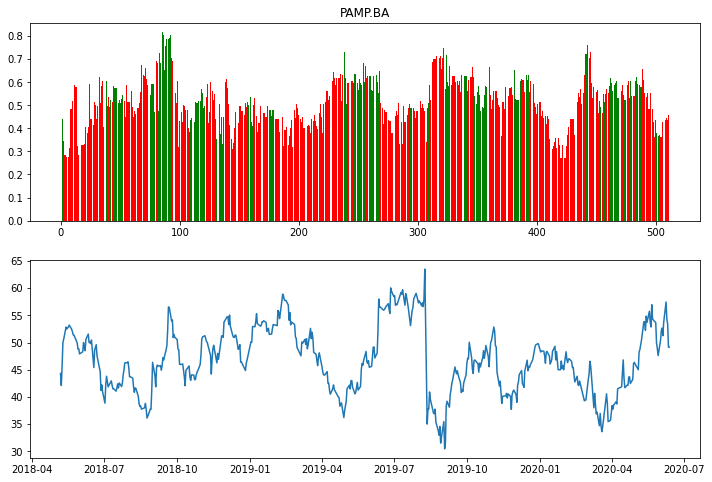

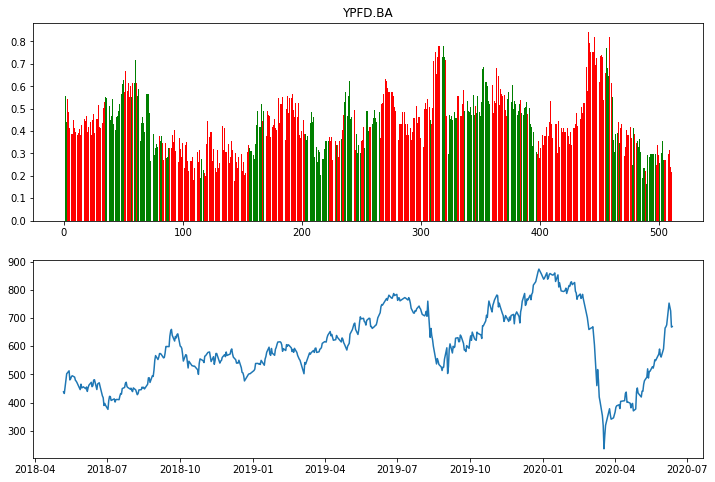

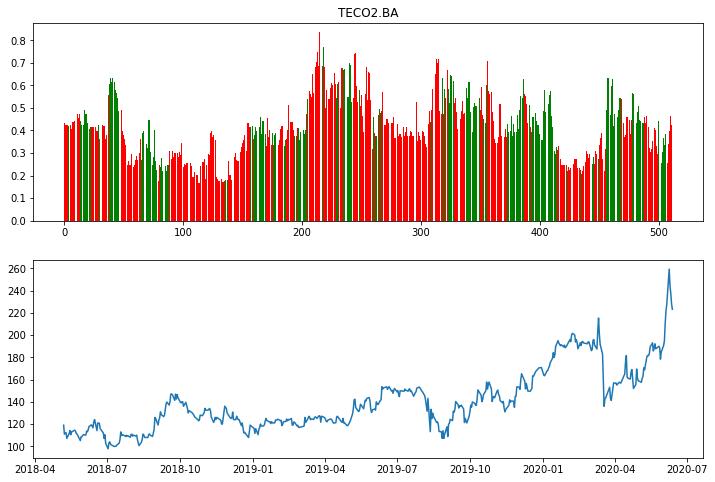

In [ ]:
for ticker in id_test.ticker.unique():
  toplot = id_test[(id_test.ticker == ticker)]

  ds = toplot[['fc']].to_numpy()
  y = toplot[['y']].to_numpy()

  ds_list = tuple(ds.reshape(1, -1)[0])
  efec_lis = toplot['efec'].tolist()
  col = []
  for vela in efec_lis:
      if vela < 0.75:
          col.append('red')
      elif vela >= 0.75:
          col.append('green')

  pred_list = toplot['pred'].tolist()
  y_pos = np.arange(len(ds_list))

  plt.figure(figsize=(12,8))
  plt.subplot(211)
  plt.title(ticker) 
  plt.bar(y_pos, pred_list, color=col)
  plt.subplot(212)
  plt.plot(ds, y)
  plt.show()